<a href="https://colab.research.google.com/github/nasiksami/Deep-Learning/blob/main/Pneumonia_Diagnosis_using_VGG19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Link: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia **

In [1]:
# Install Kaggle API
!pip install --quiet kaggle

In [3]:
# Choose kaggle.json that created for new API token in your account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nasiksami","key":"91bbb2edb4273365531b811ec9c0f46c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:28<00:00, 36.6MB/s]
100% 2.29G/2.29G [00:28<00:00, 85.7MB/s]


In [6]:
!kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55           1548  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           3649  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           1748  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           6942  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [7]:
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [8]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataset
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [9]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


In [10]:
train_path = '/content/chest_xray/train'
valid_path = '/content/chest_xray/test'

In [11]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [12]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [13]:
  # useful for getting number of classes
folders = glob('/content/chest_xray/train/*')

In [14]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [15]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [16]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [17]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [18]:
from keras.preprocessing.image import ImageDataset

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
163/163 [==============================] - 108s 660ms/step - loss: 0.1900 - accuracy: 0.9258 - val_loss: 0.2496 - val_accuracy: 0.9135
Epoch 2/5
163/163 [==============================] - 108s 663ms/step - loss: 0.1094 - accuracy: 0.9576 - val_loss: 0.3229 - val_accuracy: 0.9151
Epoch 3/5
163/163 [==============================] - 107s 659ms/step - loss: 0.1029 - accuracy: 0.9617 - val_loss: 0.2820 - val_accuracy: 0.9135
Epoch 4/5
163/163 [==============================] - 107s 659ms/step - loss: 0.0910 - accuracy: 0.9653 - val_loss: 0.5641 - val_accuracy: 0.8622
Epoch 5/5
163/163 [==============================] - 107s 659ms/step - loss: 0.0847 - accuracy: 0.9707 - val_loss: 0.3271 - val_accuracy: 0.9151


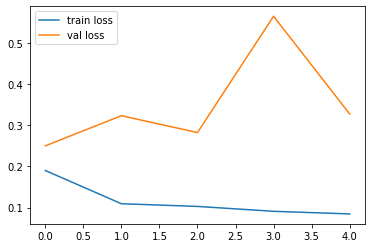

<Figure size 432x288 with 0 Axes>

In [21]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

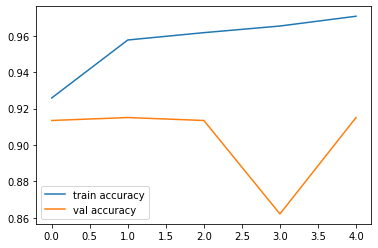

<Figure size 432x288 with 0 Axes>

In [23]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
import tensorflow as tf
from keras.models import load_model
model.save('/content/drive/MyDrive/Chest_xray_model_vgg19.h5')

In [25]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model = load_model('/content/drive/MyDrive/Chest_xray_model_vgg19.h5')
img = image.load_img('/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

In [26]:
print(classes)

[[1.198211e-12 1.000000e+00]]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


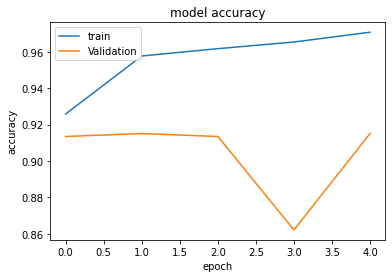

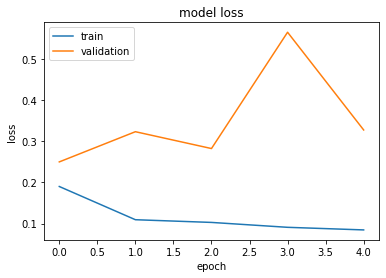

In [33]:

# list all data in history
print(r.history.keys())
# summarize history for accuracy
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [38]:
training_set.reset()
score = model.evaluate_generator(training_set, (training_set.samples + (32-1)) // 32)
print("For training data set; Loss: ",score[0]," Accuracy: ", score[1])

For training data set; Loss:  0.056330159306526184  Accuracy:  0.9798696041107178


In [56]:
test_set.reset()
score = model.evaluate_generator(test_set, (test_set.samples + (32-1)) // 32)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  0.32709503173828125  Accuracy:  0.9150640964508057
